In [ ]:
!conda install numba


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time


Importamos las librerías necesarias (Falta explicarlas)

In [2]:
class Hamiltoniano:
    def __init__(self, N, J, G, matrices_pauli):
        self.N = N  # Número de spins (o iteraciones)
        self.J = J  # Interacción entre spins
        self.G = G  # Campo magnético
        self.pauli_x, self.pauli_y, self.pauli_z, self.identidad = matrices_pauli
        # Inicializa el Hamiltoniano como una matriz de ceros de tamaño 2^N x 2^N
        self.Hamiltoniano = np.zeros((2**N, 2**N)) 

    # Método para calcular el producto directo de matrices
    def productodirecto(self, lista_matrices):
        resultado = lista_matrices[0]  # Inicializa el resultado con la primera matriz
        for k in lista_matrices[1:]:  # Itera sobre las matrices restantes
            resultado = np.kron(resultado, k)  # Calcula el producto de Kronecker
        return resultado
    
    # Método para construir el Hamiltoniano del modelo Ising
    def creacion_Hamiltoniano(self):
        # Parte del Hamiltoniano relacionada con pauli_z
        for i in range(self.N - 1):
            lista_matrices = [self.identidad] * self.N  # Crea una lista con N matrices identidad
            lista_matrices[i] = self.pauli_z  # Sustituye la i-ésima posición por la matriz pauli_z
            lista_matrices[i + 1] = self.pauli_z  # Sustituye la (i+1)-ésima posición por la matriz pauli_z
            # Actualiza el Hamiltoniano restando la contribución de la interacción entre spins
            self.Hamiltoniano -= self.J * self.productodirecto(lista_matrices)  

        # Parte del Hamiltoniano relacionada con el pauli_x
        for i in range(self.N):
            lista_matrices = [self.identidad] * self.N  # Crea otra lista con N matrices identidad
            lista_matrices[i] = self.pauli_x  # Sustituye la i-ésima posición por la matriz pauli_x
            # Actualiza el Hamiltoniano restando la contribución del campo magnético
            self.Hamiltoniano -= self.G * self.productodirecto(lista_matrices) 
        
    # Método para mostrar el Hamiltoniano
    def mostrar_Hamiltoniano(self):
        print(self.Hamiltoniano)  # Imprime el Hamiltoniano

Creamos una clase llamada Hamiltoniano

In [3]:
# Definición de las matrices de Pauli y la matriz identidad
paulix = np.array([[0, 1],
                    [1, 0]])  # Matriz de Pauli X
pauliy = np.array([[0, 1j],
                    [-1j, 0]])  # Matriz de Pauli Y
pauliz = np.array([[1, 0],
                    [0, -1]])  # Matriz de Pauli Z
identidad = np.eye(2)  # Matriz identidad de 2x2

Matrices = [paulix, pauliy, pauliz, identidad] # Lista con las matrices necesarias

Definimos las matrices de Pauli y la identidad. Las guardamos en una lista para pasarlas como argumento del Hamiltoniano

In [4]:
# Parámetros del modelo Ising
N = 1
J = 1.0  
G = 1.0  

# Cálculo del Hamiltoniano
Hamilton = Hamiltoniano(N, J, G, Matrices)  # Crea una instancia de la clase Hamiltoniano
Hamilton.creacion_Hamiltoniano()  # Construye el Hamiltoniano
Hamilton.mostrar_Hamiltoniano()  # Imprime el Hamiltoniano

[[ 0. -1.]
 [-1.  0.]]


Creamos el Hamiltoniano. Ahora procederemos a utilizarlo para resolver la ecuación diferencial utilizando el método RK4

In [ ]:
# Definición de la ecuación de Schrödinger
def Ec_Schrodinger(H, onda):
    return -1j * np.dot(H, onda) 

# Método de Runge-Kutta de cuarto orden (RK4)
def rk4(func, H, onda, h):
    k1 = h * func(H, onda)
    k2 = h * func(H, onda + 0.5 * k1)
    k3 = h * func(H, onda + 0.5 * k2)
    k4 = h * func(H, onda + k3)
    
    return onda + (1/6) * (k1 + 2 * k2 + 2 * k3 + k4)

@njit(parallel=True)
def evolucion_tiempo(times, onda, h, H):
    resultado = np.zeros(times.size)
    for i in prange(times.size):  # Aquí usamos prange para paralelizar el bucle
        resultado[i] = onda[0].real
        onda = rk4(Ec_Schrodinger, H, onda, h)
    return resultado
print(f"Tiempo que duró: {time.time() - t1}") # Tiempo que duró en realizarse el método


# Configuración de tiempos y condiciones iniciales
times = np.linspace(0.0, 10.0, 1024) # Tiempo
h = times[1] - times[0] # Espaciamiento
onda = np.zeros(2**N, dtype=complex) 

onda[0] = 1.0 # Estado inicial de la onda

# Evolución en el tiempo
t1 = time.time() # Para medir cuanto dura el método


# Gráfica del resultado
plt.plot(times, resultado, label="Parte real de Psi(t)", color='b')
plt.xlabel("Tiempo (t)", fontsize=12)
plt.ylabel("Re[Psi(t)]", fontsize=12)
plt.legend()
plt.show()


In [8]:
def evolucion_temporal(onda_inicial, t, autovalores, autovectores): #Función para evaluar la solución directamente,
    #equivalente a la Ecuación (3) del documento de proyectos finales
   
    onda_nueva = np.dot(autovectores.conj().T, onda_inicial)
    
   
    onda_t = np.dot(autovectores, np.exp(-1j * autovalores * t) * onda_nueva)
    
    return onda_t

In [10]:
onda_inicial = np.zeros(2**N, dtype=complex)  
onda_inicial[0] = 1.0 
tiempo_inicial = time.time()  
autovalores, autovectores = np.linalg.eigh(Hamilton.Hamiltoniano) 
tiempo_diagonalización = time.time() - tiempo_inicial  


resultado2 = np.zeros(times.size, dtype=complex)
tiempo_inicial_evolucion = time.time() 

for i in range(times.size):
    onda_t = evolucion_temporal(onda_inicial, times[i], autovalores, autovectores) 
    resultado2[i] = onda_t[0].real
    
    
tiempo_evolucion = time.time() - tiempo_inicial_evolucion  
print(f"Tiempo de evolución temporal: {tiempo_evolucion:.4f} s") 
print(f"Tiempo total: {tiempo_diagonalización + tiempo_evolucion:.4f} s")  
     

Tiempo de evolución temporal: 13.2289 s
Tiempo total: 15.4015 s


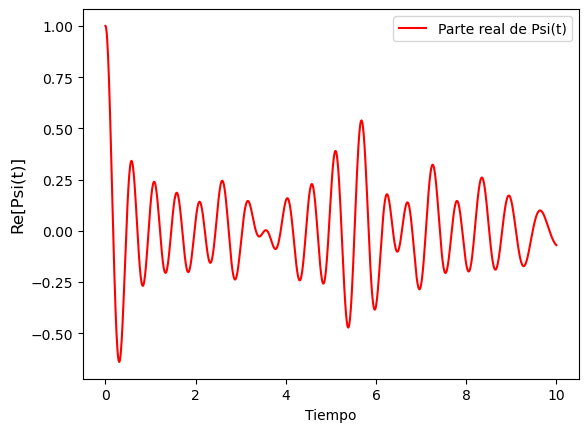

In [11]:
plt.figure()
plt.plot(times,  resultado2.real, label="Parte real de Psi(t)", color='r')  
plt.xlabel('Tiempo')
plt.ylabel("Re[Psi(t)]", fontsize=12)
plt.legend()
plt.show()